In [9]:
import seaborn as sns
# set font-scale
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
PV = "age"
if PV == "age":
    groups = ["old", "young"]
else:
    groups = ["male", "female"]
metrics = [
    (f"test/lungOpacity_{groups[0]}_fpr@0.95", f"test/lungOpacity_{groups[1]}_fpr@0.95", "fpr@0.95tpr"),
    (f"test/lungOpacity_{groups[0]}_tpr@0.05", f"test/lungOpacity_{groups[1]}_tpr@0.05", "tpr@0.05fpr"),
    (f"test/lungOpacity_{groups[0]}_anomaly_score", f"test/lungOpacity_{groups[1]}_anomaly_score", "anomaly score"),
    (f"test/lungOpacity_{groups[0]}_AUROC", f"test/lungOpacity_{groups[1]}_AUROC", "AUROC"),
    (f"test/lungOpacity_{groups[0]}_subgroupAUROC", f"test/lungOpacity_{groups[1]}_subgroupAUROC", "subgroupAUROC"),
    (f"test/lungOpacity_{groups[0]}_AP", f"test/lungOpacity_{groups[1]}_AP", "AP")
]
metrics_unwrapped = [item for sublist in [m[0:2] for m in metrics] for item in sublist]

In [11]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            dfs.append(results_df)
    df = pd.concat(dfs)
    return df

In [12]:
df = load_csvs_into_df('./')
df['weight'] = df['weigh_loss'].str.extract(r'.*_([0-9]+.[0-9]+)').astype(float)
df = df[['seed','weight',*metrics_unwrapped,'protected_attr_percent']]
df = pd.melt(df, id_vars=['seed','protected_attr_percent','weight'])
df.head()

,seed,protected_attr_percent,weight,variable,value
0,2,0.5,0.01,test/lungOpacity_old_fpr@0.95,0.92
1,1,0.5,0.01,test/lungOpacity_old_fpr@0.95,0.96
2,8,0.5,0.01,test/lungOpacity_old_fpr@0.95,0.98
3,5,0.5,0.01,test/lungOpacity_old_fpr@0.95,0.98
4,6,0.5,0.01,test/lungOpacity_old_fpr@0.95,0.98


In [13]:
# load effective_dataset_size 1 from other experiment
df_1 = load_csvs_into_df('../2023-09-02 22:38:35-FAE-rsna-age-bs32-noDP')
df_1 = df_1[['seed',*metrics_unwrapped,'protected_attr_percent']]
df_1['weight'] = 1
df_1 = pd.melt(df_1, id_vars=['seed','protected_attr_percent','weight'])
df_1 = df_1[df_1.protected_attr_percent.isin(df.protected_attr_percent.unique())]
df_1.head()

,seed,protected_attr_percent,weight,variable,value
15,2,0.25,1,test/lungOpacity_old_fpr@0.95,0.76
16,1,0.25,1,test/lungOpacity_old_fpr@0.95,0.72
17,5,0.25,1,test/lungOpacity_old_fpr@0.95,0.76
18,3,0.25,1,test/lungOpacity_old_fpr@0.95,0.72
19,4,0.25,1,test/lungOpacity_old_fpr@0.95,0.74


In [14]:
df = pd.concat([df,df_1])
df = df.sort_values(by=['protected_attr_percent','weight',"variable"], ascending=False)

In [15]:
def generate_plot(sub,metric,split):
    sub.variable = sub.variable.str.replace(metric[1],groups[1])
    sub.variable = sub.variable.str.replace(metric[0],groups[0])
    plt.figure(figsize=(12,4))
    g = sns.barplot(data=sub, x="weight", y="value", hue="variable")
    sub_sizes = sub.weight.unique()
    custom_colors = ["#5975A4"]*(len(sub_sizes)-1) + ["#79a0e0"] + ["#CC8963"]*(len(sub_sizes)-1) + ["#e1a07a"]
    for i, bar in enumerate(g.patches):
        bar.set_color(custom_colors[i])
    plt.title(f'Fraction of "old" subgroup in training data: {split*100:.0f}%')
    plt.xlabel('weight on loss of "old" subgroup')
    plt.ylabel(metric[2])
    plt.legend(loc="lower right")
    plt.savefig(f"fig{split}.pdf",bbox_inches='tight')
    plt.show()

The 'most fair' weight is at index 9 with size 0.1


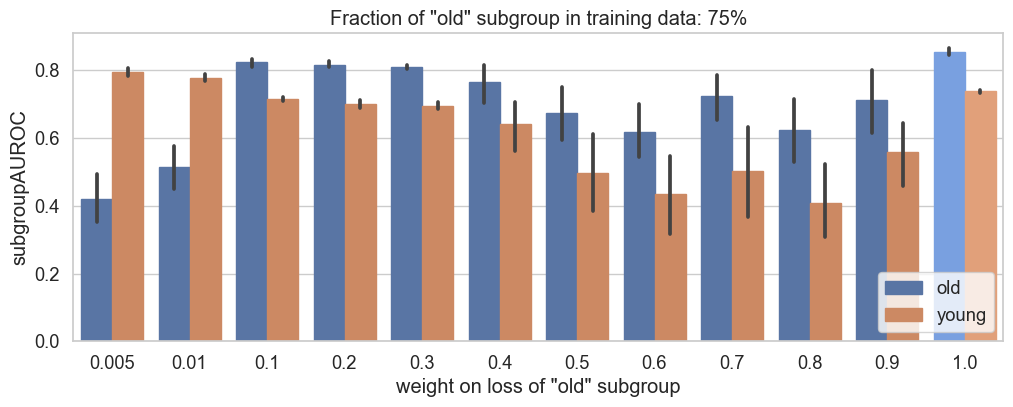

The 'most fair' weight is at index 0 with size 1.0


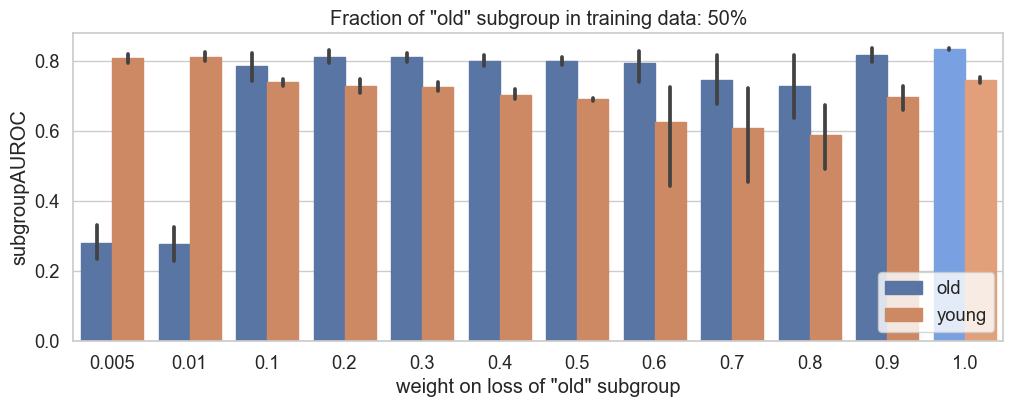

The 'most fair' weight is at index 0 with size 1.0


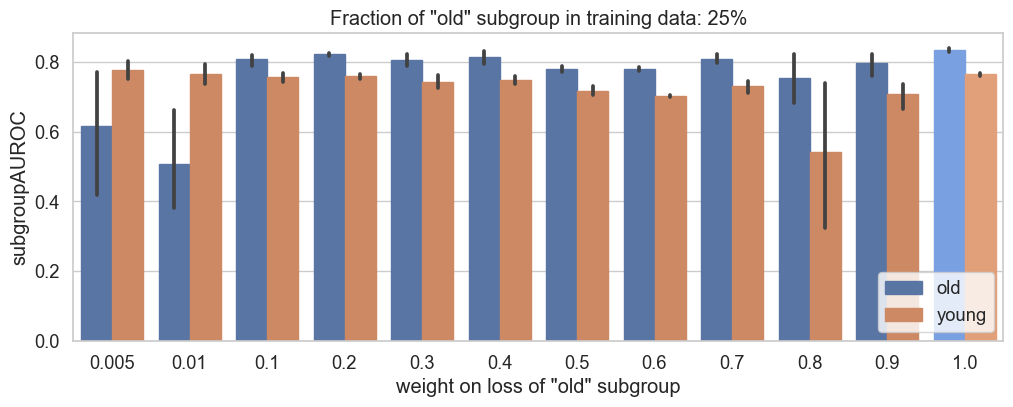

In [16]:
for split in df.protected_attr_percent.unique():
    auroc_only = True
    for metric in metrics:
        if auroc_only and 'subgroupAUROC' not in metric[0]:
            continue
        min_dist = np.inf
        best_dss = None
        best_dss_max = None
        best_dss_min = None
        sub = df.loc[df['variable'].isin(metric[0:2]) & (df.protected_attr_percent==split)]
        sub_sizes = sub.weight.unique()
        for idx, w in enumerate(sub_sizes):
            sub_w = sub[sub.weight==w]
            dist = sub_w.value.max() - sub_w.value.min()
            if dist < min_dist:
                min_dist = dist
                best_dss = idx
                best_dss_max = sub_w.value.max()
                best_dss_min = sub_w.value.min()
        print("The 'most fair' weight is at index", best_dss, "with size", sub_sizes[best_dss])
        # sort sub by variable
        sub = sub.sort_values(by=['variable'], ascending=True)
        generate_plot(sub, metric, split)